# Object Detection and tracking in video
โค้ดนี้เป็นตัวอย่างของการใช้โมเดลในการตรวจจับวัตถุในวิดีโอ การติดตามวัตถุ และการวิเคราะห์ข้อมูลที่ได้จากการตรวจจับ ซึ่งสามารถนำไปประยุกต์ใช้ในงานด้านการวิเคราะห์วิดีโอ การตรวจสอบคุณภาพในสายการผลิต หรือการติดตามการเคลื่อนไหวของวัตถุในวิดีโอได้



## การติดตั้งและนำเข้าไลบรารี
ติดตั้ง ultralytics ซึ่งเป็นไลบรารีสำหรับ YOLO และนำเข้าไลบรารีที่จำเป็นอื่นๆ

In [ ]:
!pip install ultralytics --quiet
exit()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 22.4 MB/s eta 0:00:00


### import

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from IPython.display import display, Image
import plotly.express as px
import time
import math

## การเตรียมข้อมูลและโหลดโมเดล
ดาวน์โหลดไฟล์วิดีโอและโมเดล YOLO ที่ผ่านการเทรนมาแล้ว จากนั้นโหลดโมเดลเข้าสู่หน่วยความจำ

In [7]:
!pip install --upgrade gdown --quiet

In [8]:
!gdown 1RfNxo4AFAdTuzkIRc5jtYzC_-HrugKFu  # ดาวน์โหลดวิดีโอ
!gdown 14mmqJpYLrglsHeQxpy7DjHxBCJbF5F9j  # ดาวน์โหลดโมเดลที่ฝึกไว้แล้ว

Downloading...
From (original): https://drive.google.com/uc?id=1RfNxo4AFAdTuzkIRc5jtYzC_-HrugKFu
From (redirected): https://drive.google.com/uc?id=1RfNxo4AFAdTuzkIRc5jtYzC_-HrugKFu&confirm=t&uuid=63036051-4b7d-43e6-a8ca-b37ea18e020a
To: c:\AI_workshop\empty4.mp4

  0%|          | 0.00/395M [00:00<?, ?B/s]
  0%|          | 524k/395M [00:00<02:33, 2.57MB/s]
  0%|          | 1.57M/395M [00:00<01:10, 5.61MB/s]
  1%|          | 3.15M/395M [00:00<00:45, 8.57MB/s]
  1%|▏         | 5.24M/395M [00:00<00:32, 12.1MB/s]
  2%|▏         | 7.34M/395M [00:00<00:27, 14.2MB/s]
  2%|▏         | 8.91M/395M [00:00<00:26, 14.6MB/s]
  3%|▎         | 11.5M/395M [00:00<00:22, 17.0MB/s]
  3%|▎         | 13.6M/395M [00:01<00:26, 14.6MB/s]
  4%|▍         | 17.3M/395M [00:01<00:19, 19.2MB/s]
  5%|▍         | 19.4M/395M [00:01<00:19, 18.9MB/s]
  5%|▌         | 21.5M/395M [00:01<00:19, 19.4MB/s]
  6%|▌         | 23.6M/395M [00:01<00:19, 19.4MB/s]
  7%|▋         | 25.7M/395M [00:01<00:19, 19.2MB/s]
  7%|▋         | 2

In [28]:
model = YOLO("yolov8s-seg-blade.pt")  # load a pretrained model (recommended for training)
model.fuse()

c:\AI_workshop\AI\Lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


YOLOv8s-seg summary (fused): 195 layers, 11780761 parameters, 0 gradients, 42.4 GFLOPs


In [35]:
model.fuse()

# Workshop 15 การติดตามวัตถุโดยการเทียบระยะห่างจากตำแหน่งก่อนหน้า

## การประมวลผลวิดีโอ
วนลูปผ่านทุกเฟรมของวิดีโอ ตรวจจับวัตถุในแต่ละเฟรม และบันทึกข้อมูลตำแหน่งของวัตถุที่ตรวจพบ

In [52]:
def initial_id(blade, frame_id):
    obj_id = 0
    new_blade = np.zeros((blade.shape[0], 6))
    for i in range(blade.shape[0]):
        new_blade[i,0] = frame_id
        new_blade[i,1] = obj_id
        new_blade[i,2:] = blade[i]
        obj_id += 1
    # blade[:,0] = np.arange(blade.shape[0])
    return new_blade

In [82]:
THRESHOLD = 100

def euclidean_distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def fill_id(blade, tracked_objs, max_objs_id, frame_id):
    checked_obj = np.zeros((blade.shape[0], 6))
    for i in range(blade.shape[0]):
        found = False
        for j in range(len(tracked_objs)):
            print(tracked_objs)
            if euclidean_distance(blade[i,0:2], tracked_objs[j][2:4]) < THRESHOLD:
                blade[i,0] = tracked_objs[j][0]
                found = True
                break
            
        if not found:
            max_objs_id +=1
            blade[i, 1] = max_objs_id
        checked_obj[i,0] = frame_id
        checked_obj[i,2:] = blade[i,:]
        
    return checked_obj, max_objs_id
    


0: 640x640 1 blade, 239.0ms
Speed: 3.0ms preprocess, 239.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


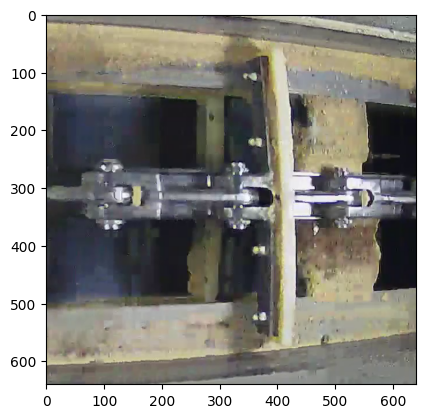


0: 640x640 1 blade, 206.0ms
Speed: 4.0ms preprocess, 206.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
[array([[          0,           0,      405.49,      314.21,      55.423,      498.55]])]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [83]:
# row = 
# col = 
cap = cv2.VideoCapture('empty4.mp4')
ret, frame = cap.read()
frame_count = 0
tracked_objs = []
while ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame[270:270+640, 1100:1100+640, :]
    result = model.predict(frame)
    objs = result[0].boxes.xywh.cpu().numpy()
    if frame_count == 0:
        objs = initial_id(objs, frame_id=0)
        tracked_objs.append(objs)
        max_objs_id = objs.shape[0]-1
    else:
        checked_obj, max_objs_id = fill_id(objs, tracked_objs, max_objs_id, frame_count)
        tracked_objs.append(checked_obj)
    
    
    
    # print(result[0].boxes.xywh)
    # print(result[0].boxes.cls)
    # print(result[0].boxes.conf)
    plt.imshow(frame)
    plt.show()
    if frame_count == 10 :
        break
    ret, frame = cap.read()
    frame_count += 1
cap.release()

In [75]:
tracked_objs

[array([[          0,           0,      405.49,      314.21,      55.423,      498.55]]),
 array([[          1,           0,           0,      314.25,      55.426,       498.6]]),
 array([[          2,           0,           1,      302.99,      48.336,      534.68],
        [          2,           0,           0,      318.13,      45.819,      496.84]]),
 array([[          3,           0,           1,      305.85,      50.392,      537.31],
        [          3,           0,           0,      314.76,       50.16,      483.28]]),
 array([[          4,           0,       146.5,           1,      51.661,      540.54],
        [          4,           0,      540.09,           2,      54.843,      472.34]]),
 array([[          5,           0,      202.76,           3,      50.566,      530.92],
        [          5,           0,       579.2,           4,      40.349,      456.22]]),
 array([[          6,           0,      262.86,           5,      47.828,      526.76],
        [          6

In [47]:
print(objs)

[[          0           0      405.49      314.21      55.423      498.55]]


## เก็บภาพที่คิดว่าน่าจะมีปัญหา

In [20]:
!rm -r /content/problem
!mkdir /content/problem

The syntax of the command is incorrect.


In [11]:
from logging import exception
import shutil

In [ ]:
problem=filtered_df[filtered_df['label']=='center']
problem=problem[problem['width']>80]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile('/content/frames/im{:05d}.jpg'.format(ff), '/content/problem/im{:05d}.jpg'.format(ff))
    except:
        pass

In [ ]:
problem=filtered_df[filtered_df['label']=='top']
problem=problem[problem['width']>60]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile('/content/frames/im{:05d}.jpg'.format(ff), '/content/problem/im{:05d}.jpg'.format(ff))
    except:
        pass

In [ ]:
problem=filtered_df[filtered_df['label']=='bottom']
problem=problem[problem['width']>60]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile('/content/frames/im{:05d}.jpg'.format(ff), '/content/problem/im{:05d}.jpg'.format(ff))
    except:
        pass

# Workshop 16 เพิ่มการทำนายตำแหน่งถัดไป

## ปรับปรุงการแสดงผล

In [ ]:
def draw_id(img,tracked_blade):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
    img = cv2.putText(img, 'Frame:{:05d}'.format(int(tracked_blade[0,1])), (50,50), font,
                   fontScale, color, thickness, cv2.LINE_AA)
    for i in range(tracked_blade.shape[0]):
        posi=(int(tracked_blade[i,2]),int(tracked_blade[i,3]))
        img = cv2.putText(img, 'ID:{:02d}'.format(int(tracked_blade[i,0])), posi, font,
                   fontScale, color, thickness, cv2.LINE_AA)
    return img

## เพิ่มการทำนายตำแหน่ง

# การปรับปรุงการติดตามวัตถุ

## delete duplicate
การจัดการกับวัตถุที่ซ้ำซ้อน และ

In [ ]:
def clean_twin(blade):
    keep=[True for _ in range(blade.shape[0])]
    for i in range(blade.shape[0]-1):
        for j in range(i+1,blade.shape[0]):
            if euclidean_distance(blade[i,2:4],blade[j,2:4])<THRESHOLD:
                keep[j]=False
    return blade[keep,:]

## Object re-registration
ส่วนนี้เป็นการปรับปรุงกระบวนการติดตามวัตถุ ให้มีประสิทธิภาพมากขึ้น โดยรองรับกรณีที่การตรวจจับวัตถุล้มเหลว หรือไม่มีวัตถุใหม่ที่ตรงกับตำแหน่งที่ทำนายไว้ ผมจะอธิบายแนวคิดและโค้ดที่เกี่ยวข้องดังนี้:

แนวคิด:
เมื่อไม่สามารถตรวจจับวัตถุใหม่ที่ตรงกับตำแหน่งที่ทำนายไว้ แทนที่จะละทิ้งข้อมูลการติดตามนั้น เราจะรวมตำแหน่งที่ทำนายไว้เข้าไปในกระบวนการติดตาม ทำให้สามารถติดตามวัตถุได้ต่อเนื่อง แม้ในบางเฟรมจะไม่สามารถตรวจจับวัตถุได้

In [ ]:
def get_id(blade,tracked_blade,count,threshold): # return id and max count
    for i in range(tracked_blade.shape[0]):
        if euclidean_distance(blade[2:4],tracked_blade[i,2:4])<threshold:
            return tracked_blade[i,0],count,i
    nex_id=count+1
    return nex_id, nex_id, None


def fill_id(blades,tracked_blade,count,threshold=50):
    notpaired=[True for _ in range(tracked_blade.shape[0])]
    for i in range(blades.shape[0]):
        blades[i,0],count,ind=get_id(blades[i,:],tracked_blade,count,threshold)
        if ind is not None:
            notpaired[ind]=False
    tracked_blade=tracked_blade[notpaired,:]
    tracked_blade[:,1]=blades[0,1]
    blades=np.r_[blades,tracked_blade]
    return blades,count